# Import all packages and define functions used for data-preprocessing 
# Reads the dataset

In [14]:
#### Import all packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydot

## Models used in the assignment
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn import tree, neighbors, svm
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import RFE
from io import StringIO
from sklearn.tree import export_graphviz

import warnings
# To ignore any future warnings
warnings.filterwarnings("ignore")

# Repeated functions
def getMode(df, attribute, condAtt, cond):
    return (df[attribute][df[condAtt]==cond].mode()[0])

def replaceWithMode(df, attribute, condAtt, cond):
    mode = getMode(df, attribute, condAtt, cond)
    df[attribute] = df[attribute].mask(((df[condAtt]==cond) & (df[attribute]=='?')), mode)
    

# read the dataset and set skipinitialspace to true to be able to .replace
df = pd.read_csv('./HouseholderAtRisk(1).csv', skipinitialspace=True)
# df.info()

rs = 10

# Task 1 
**1)      What proportion of households who have high risk?**

Properties with high risks are calculated with value_counts

In [2]:
# Task 1 question 1
# Show proportion of high risk
risks = df['AtRisk'].value_counts()
print("Proportion of high risk = " + str(risks[0]/len(df)))

Proportion of high risk = 0.7624690617265432


# Task 1
**2) Did you have to fix any data quality problems? Detail them**


Pre-processing for tasks 2 and 3


In [20]:
def data_prep():
    # read the pva97nk dataset
    df = pd.read_csv('./HouseholderAtRisk(1).csv', skipinitialspace=True)
    # Drop rows with multiple columns containing NaN values
    df = df.dropna(subset=["Relationship", "Sex", "NumYearsEducation"], how='all')

    # Replace inconsistency in CountryOfOrigin
    df['CountryOfOrigin'] = df['CountryOfOrigin'].replace("US", "USA").replace("United-States", "USA")

    ##Replace ? to mode in CountryOfOrigin
    modeCountry = df['CountryOfOrigin'].mode()[0]
    df.loc[df['CountryOfOrigin']=='?', 'CountryOfOrigin'] = modeCountry

    # Removing Gender to use numerical binary for Sex where 0 = Male, 1 = Female
    df.drop('Gender', axis=1, inplace=True)

    # Replace -1 value in Age with mean value
    modeAge = df['Age'].mode()[0]
    df.loc[df['Age']==-1, 'Age'] = modeAge

    # Round off age
    df['Age'] = df['Age'].astype(int)

    # Drop race as there are 39954 NaN vs 45 labelled classes
    df.drop('Race', axis=1, inplace=True)


    # Sets upper boundary of 90 hours work week in NumWorkingHoursPerWeek and fills with mean value
    modeWorkHours = df['NumWorkingHoursPerWeek'].mode()[0]
    df['NumWorkingHoursPerWeek'] = df['NumWorkingHoursPerWeek'].where(df['NumWorkingHoursPerWeek'] <= 90, modeWorkHours)  
    # Round off hours                             
    df['NumWorkingHoursPerWeek'] = df['NumWorkingHoursPerWeek'].astype(int)

    # Replaces missing data with mean of column
    df['Weighting'] = df['Weighting'].fillna(df['Weighting'].mean())


    # Replaces missing data with unknown Occupation
    df['Occupation'] = df['Occupation'].fillna("?")

    # Replaces unknowns with the mode of attribute
    # By WorkClass
    replaceWithMode(df,'Occupation','WorkClass','Federal-gov')
    replaceWithMode(df,'Occupation','WorkClass','Self-emp-inc')
    replaceWithMode(df,'Occupation','WorkClass','Private')
    replaceWithMode(df,'Occupation','WorkClass','Never-worked')

    # By education
    for values in df['Education'].unique():
        replaceWithMode(df, 'Occupation', 'Education', values)
        replaceWithMode(df, 'WorkClass', 'Education', values)


    # Never-worked adults will have occupation set as other services as a generic unknown
    df['Occupation'] = df['Occupation'].mask(((df['WorkClass']=='Never-worked') & (df['Occupation']=='?')), "Other-service")

    ###Mappings

    atriskclassMapping = {'High': 1, 'Low':0} #Binary

    workclassMapping = {'Private':0, 'Local-gov': 1, 'Self-emp-not-inc':2, 'Federal-gov': 3, 'State-gov': 4,  'Self-emp-inc': 5\
                        ,'Without-pay':6, 'Never-worked':7}

    educationclassMapping = {'Preschool':0,'1st-4th': 1, '5th-6th': 2, '7th-8th': 3, '9th': 4, '10th': 5,
           '11th':6, '12th':7,'HS-grad':8, 'Some-college':9, 'Bachelors':10, 'Prof-school':11, 'Masters': 12, 'Doctorate': 13,
                             'Assoc-acdm': 14, 'Assoc-voc': 15} #Ordinal?? not sure of order

    maritalstatusclassMapping = {'Never-married': 0, 'Married-civ-spouse': 1, 'Widowed': 2, 'Divorced':3,
           'Separated':4, 'Married-spouse-absent':5, 'Married-AF-spouse':6 }

    occupationclassMapping = {'Machine-op-inspct': 0 , 'Farming-fishing': 1, 'Protective-serv': 2,
           'Adm-clerical': 3, 'Other-service': 4, 'Craft-repair': 5, 'Prof-specialty': 6,
           'Exec-managerial': 7, 'Tech-support': 8, 'Sales': 9, 'Priv-house-serv': 10,
           'Transport-moving': 11, 'Handlers-cleaners': 12, 'Armed-Forces': 13}

    relationshipclassMapping = {'Own-child': 0, 'Husband':1, 'Not-in-family':2, 'Unmarried':3, 'Wife':4,
           'Other-relative':5}

    # By continent 
    countryclassMapping = {'USA':1, 'Peru':1, 'Guatemala':1, 'Mexico':1, 'Dominican-Republic':1,
           'Ireland':2, 'Germany':2, 'Philippines':3, 'Thailand':3, 'Haiti':1,
           'El-Salvador':1, 'Puerto-Rico':1, 'Vietnam':3, 'South':3, 'Columbia':1,
           'Japan':3, 'India':4, 'Cambodia':1, 'Poland':2, 'Laos':3, 'England':2, 'Cuba':1,
           'Taiwan':2, 'Italy':2, 'Canada':1, 'Portugal':2, 'China':3, 'Nicaragua':1,
           'Honduras':1, 'Iran':4, 'Scotland':2, 'Jamaica':1, 'Ecuador':1, 'Yugoslavia':1,
           'Hungary':2, 'Hong':3, 'Greece':2, 'Trinadad&Tobago':1,
           'Outlying-US(Guam-USVI-etc)':1, 'France':2, 'Holand-Netherlands':2}

    df['AtRisk'] = df['AtRisk'].map(atriskclassMapping).astype(int)
    df['WorkClass'] = df['WorkClass'].map(workclassMapping).astype(int)
    df['Education'] = df['Education'].map(educationclassMapping).astype(int)
    df['Marital-Status'] = df['Marital-Status'].map(maritalstatusclassMapping).astype(int)
    df['Occupation'] = df['Occupation'].map(occupationclassMapping).astype(int)
    df['Relationship'] = df['Relationship'].map(relationshipclassMapping).astype(int)
    df['CountryOfOrigin'] = df['CountryOfOrigin'].map(countryclassMapping).astype(int)
    df['NumYearsEducation']= df['NumYearsEducation'].astype(int)
    
    return df


## Task 2 Pre-processing
**Specific pre-processing for Decision Tree Model**


In [19]:
dfDT = data_prep()
# Turning CapitalAvg into binary options 
dfDT['CapitalAvg'][dfDT['CapitalAvg'] > 0] = 1
dfDT['CapitalAvg'] = dfDT['CapitalAvg'].astype(int)

# Converting weight from 1 to 4 based on equal intervals (equi-width)
weightMax = dfDT['Weighting'].max()
print("The range for weightings are:", weightMax/4, weightMax/2, weightMax*3/4)
bins = [0, weightMax/4, weightMax/2, weightMax*3/4,  weightMax+1]
labels =[1,2,3,4]
dfDT['Weighting'] = pd.cut(dfDT['Weighting'], bins,labels=labels)

# Converting age from 1 to 4 based on equal intervals (equi-width)
dfDT['Age'].max()
ageMax = dfDT['Age'].max()
print("\nThe range for age are:", ageMax/4, ageMax/2, ageMax*3/4)
bins = [0, ageMax/4, ageMax/2, ageMax*3/4,  ageMax+1]
labels =[1,2,3,4]
dfDT['Age'] = pd.cut(dfDT['Age'], bins,labels=labels)

# Converting education years from 1 to 4 based on equal intervals (equi-width)
dfDT['NumYearsEducation'].max()
eduMax = dfDT['NumYearsEducation'].max()
print("\nThe range for NumYearsEducation are:", eduMax/4, eduMax/2, eduMax*3/4)
bins = [0, eduMax/4, eduMax/2, eduMax*3/4,  eduMax+1]
labels =[1,2,3,4]
dfDT['NumYearsEducation'] = pd.cut(dfDT['NumYearsEducation'], bins,labels=labels)


## Preparation of dataset
# target/input split
y = dfDT['AtRisk']
# Drop all object type
X = dfDT.drop(['ID', 'CapitalLoss', 'CapitalGain', 'AtRisk'], axis=1)

X_mat = X.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)

NameError: name 'data_prep' is not defined

# Task 2 Predictive Modelling using Decision Trees

**Dataset is split into target and input types**

By dropping ID, target variable and other object types, a decision tree can be formed.

Cross-fold validation with k=10 is done to the training set of 70%, having 7% for each fold. Then, it is fitted and ready for analysis


In [5]:
# simple decision tree training
dt = DecisionTreeClassifier(random_state=rs)
K_fold = cross_val_score(dt, X_train, y_train, cv=10)
dt.fit(X_train, y_train)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

# Task 2 

**1a) What is classification accuracy on training and test datasets?**

**b) Which variable is used for the first split? What are the variables that are used for the second split?**

In [6]:
# Task 2 1a
print("---Task 2 1a: Training and Test accuracy---")
print("Train accuracy:", dt.score(X_train, y_train))
print("Test accuracy:", dt.score(X_test, y_test))

# Task 2 1b
# grab feature importances from the model and feature name from the original X
importances = dt.feature_importances_[0:6]
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(importances)
indices = np.flip(indices, axis=0)

print("\n\n---Task 2 1b and 1c: Variables used for split---")

for i in indices:
    print(feature_names[i], ':', importances[i])
    
print("\n\n---Task 2 1d---\nOverfitting was observed as there was a significant\
difference between the test and training accuracy, showing that the model was picking out\
specific features of the training set which resulted in a better result.")

---Task 2 1a: Training and Test accuracy---
Train accuracy: 0.9230910022695659
Test accuracy: 0.8007515586301136


---Task 2 1b and 1c: Variables used for split---
Marital-Status : 0.27062482243689434
NumYearsEducation : 0.1576102469549165
WorkClass : 0.06716255151024704
Education : 0.05845210233198633
Age : 0.042880059452403835
Weighting : 0.017172064278001335


---Task 2 1d---
Overfitting was observed as there was a significantdifference between the test and training accuracy, showing that the model was picking outspecific features of the training set which resulted in a better result.


# Task 2

**2) Build another decision tree tuned with GridSearchCV**

With this, we have set the hyperparameters as the maximum depth of tree, and test against depths of 1 to 100, with cross fold validation of k=5. Then, the accuracy and scores are printed.


In [7]:
params= {'criterion': ['gini', 'entropy'],
          'max_depth': range(2, 20),
          'min_samples_leaf': range(200, 600, 100)}
tree_depth = np.arange(1,100)

gsDT = GridSearchCV(dt, param_grid=params, iid=True, cv=5)

#K_fold_prediction = cross_val_score(gs, X_train, y_train, cv=3)
#print("Accuracy: %0.2f (+/- %0.2f)" % (K_fold_prediction.mean(), K_fold_prediction.std() * 2))
#print("Cross validation scores are:", K_fold_prediction)

gsDT.fit(X_train, y_train)
    
# Task 2 2a
print("---Task 2 2a: Classification Accuracy---\n")
print("Train accuracy:", gsDT.score(X_train, y_train))
print("Test accuracy:", gsDT.score(X_test, y_test))

# Best hyperparameter
print("\n\n---Task 2 2c-e: Optimal variables---")
print (str(gsDT.best_params_))
print (str(gsDT.best_estimator_))
      
# grab feature importances from the model and feature name from the original X
importances = gsDT.best_estimator_.feature_importances_[0:6]
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(importances)
indices = np.flip(indices, axis=0)

for i in indices:
    print(feature_names[i], ':', importances[i])

---Task 2 2a: Classification Accuracy---

Train accuracy: 0.8379456768431071
Test accuracy: 0.8370484242890085


---Task 2 2c-e: Optimal variables---
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 200}
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=200, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')
Marital-Status : 0.5302760424703712
NumYearsEducation : 0.2429143818986392
Education : 0.020436176490068663
Age : 0.011204951144736101
WorkClass : 0.0015834417842989009
Weighting : 0.0


# Test for overfitting
**A validation curve is also drawn to determine if the model is overfitting**

Task 2
Q2 f) Slight overfitting

In [ ]:
train_scores, test_scores = validation_curve(
    DecisionTreeClassifier(random_state=5), X, y, param_name="max_depth", param_range=tree_depth,
    cv=5, scoring="accuracy", n_jobs=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with DT")
plt.xlabel("max_depth")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(tree_depth, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(tree_depth, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(tree_depth, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(tree_depth, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

# Displaying Decision Tree
**This is used in Task 2 question 4 to visualise characteristics and households to target**

In [ ]:
def visualize_decision_tree(dm_model, feature_names, save_name):    
    dotfile = StringIO()
    export_graphviz(dm_model, out_file=dotfile, feature_names=feature_names)
    graph = pydot.graph_from_dot_data(dotfile.getvalue())
    graph.write_png(save_name) # saved in the following file

visualize_decision_tree(gsDT.best_estimator_, X.columns, "optimal_tree.png")

# Task 3 Logistic Regression
## Scaling attributes
**First, we plot continuous attributes and see if we can spot any skewness**

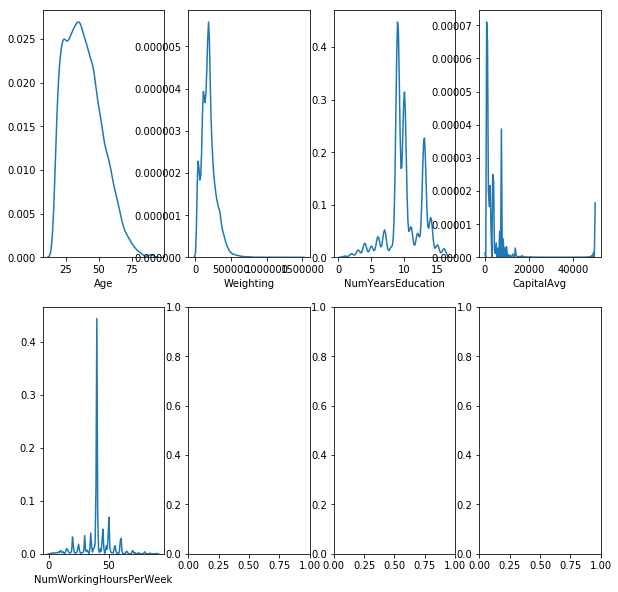

In [24]:
dfLR = data_prep()
# copy the dataframe

## Preparation of dataset
# target/input split
y = dfLR['AtRisk']
# Drop all object type
X_log = dfLR.drop(['ID', 'CapitalLoss', 'CapitalGain', 'AtRisk'], axis=1)

#age weighting numyearseducation
#capitalavg numworkinghrspreweek 
# are continuous so the rest are removed

cols_to_remove = ['Sex', 'CountryOfOrigin', 'Marital-Status', 'Occupation', 'Relationship', 'WorkClass', 'Education']
# get columns from X
cols = X_log.columns
cols = [col for col in cols]
for i in cols_to_remove:
    cols.remove(i)

# Graph for the continuous attributes
fig, ax = plt.subplots(2,4, figsize=(10,10), sharex=False)
for i, col in enumerate(cols):
    sns.distplot(X_log[col].dropna(), hist=False, ax=ax[int(i/4)][i%4])
    
plt.show()

## Additional steps taken

**To prevent skewness, certain continuous variables are transformed with a log function.
Then, the whole dataset has to be transformed to ensure gradient descents update weights on similar speed and allow us to compare equally to figure out the important features**

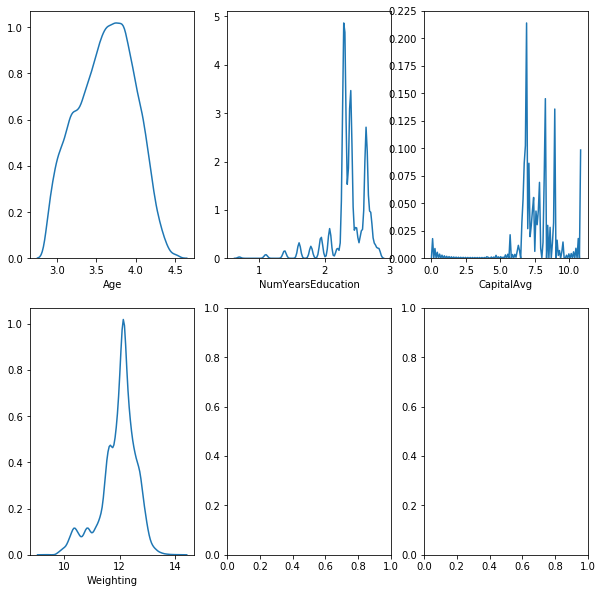

Model without GridSearchCV:
Train accuracy: 0.8164580130317007
Test accuracy: 0.8169783926893842


---Task 3 Question 2a---
Variables used are: Index(['Age', 'WorkClass', 'Weighting', 'Education', 'NumYearsEducation',
       'Marital-Status', 'Occupation', 'Relationship', 'CapitalAvg',
       'NumWorkingHoursPerWeek', 'Sex', 'CountryOfOrigin'],
      dtype='object')


---Task 3 Question 2b---
NumYearsEducation : -0.9453408223967992
Age : -0.7568223544543007
CapitalAvg : -0.5421807082146466
Sex : 0.49761123091281423
NumWorkingHoursPerWeek : -0.41774538697278496
Marital-Status : 0.20267320375263237


---Task 3 Question 2c---
No sign of overfitting as the test accuracy is higher than train accuracy


---Task 3 Question 2d---
Optimal parameters are:
 {'C': 0.1}


Model with GridSearchCV
---Task 3 Question 2e---
Train accuracy: 0.8164580130317007
Test accuracy: 0.8169783926893842


In [25]:
# list columns to be transformed
columns_to_transform = ['Age', 'NumYearsEducation', 'CapitalAvg', 'Weighting']

# transform the columns with np.log
for col in columns_to_transform:
    X_log[col] = X_log[col].apply(lambda x: x+1)
    X_log[col] = X_log[col].apply(np.log)

fig, ax = plt.subplots(2,3, figsize=(10,10), sharex=False)
for i, col in enumerate(columns_to_transform):
    sns.distplot(X_log[col].dropna(), hist=False, ax=ax[int(i/3)][i%3])
    
plt.show()

# start by splitting them again
X_mat_log = X_log.as_matrix()
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_mat_log, y, test_size=0.3, stratify=y, random_state=rs)

# scale
scaler_log = StandardScaler()
X_train_log = scaler_log.fit_transform(X_train_log)
X_test_log = scaler_log.transform(X_test_log)

# Without gridsearch
logreg = LogisticRegression(random_state=rs)
logreg.fit(X_train_log, y_train_log)
print("Model without GridSearchCV:")
print("Train accuracy:", logreg.score(X_train_log, y_train_log))
print("Test accuracy:", logreg.score(X_test_log, y_test_log))


# With gridsearch
params = {'C': [pow(10, x) for x in range(-10, 5)]}
cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
cv.fit(X_train_log, y_train_log)

print("\n\n---Task 3 Question 2a---")
print("Variables used are:", X.columns)


print("\n\n---Task 3 Question 2b---")
# best features
coef = cv.best_estimator_.coef_[0]
feature_names = X_log.columns

# sort them out in descending order
indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)

# limit to 6 features
indices = indices[:6]

for i in indices:
    print(feature_names[i], ':', coef[i])
    
print("\n\n---Task 3 Question 2c---")
print("No sign of overfitting as the test accuracy is higher than train accuracy")

# print parameters of the best model
print("\n\n---Task 3 Question 2d---")
print("Optimal parameters are:\n", cv.best_params_)

# test the best model
print("\n\nModel with GridSearchCV")
print("---Task 3 Question 2e---")
print("Train accuracy:", cv.score(X_train_log, y_train_log))
print("Test accuracy:", cv.score(X_test_log, y_test_log))


# Task 3
## Question 3 RFE model

In [ ]:
#from sklearn.svm import SVR
#Same estimator - linear regression
estimator2 = LogisticRegression(random_state=rs)
selector2 = RFE(estimator2, 5, step=1)
selector2 = selector2.fit(X_train_log, y_train_log)
print("--Task 3 Model with RFE--\n")

print("---Question 3a---\n",pd.DataFrame(feature_names))

print("\n--Question 3b--")
# best 5 features OF RFE MODEL
coef = selector2.estimator_.coef_
feature_names = X_log.columns
coefficients = pd.concat([pd.DataFrame(feature_names),pd.DataFrame(np.transpose(coef))], axis = 1)
# best 5 features value OF RFE MODEL
print (coefficients[0:5])

print("\n--Question 3c--")
print("No signs of overfitting as test accuracy is higher than train accuracy.")

print("\n--Question 3d--")
print("Train accuracy:", selector2.score(X_train_log, y_train_log))
print("Test accuracy:", selector2.score(X_test_log, y_test_log))

# Task 4 Neural Network

In [35]:
dfNN = data_prep()
# copy the dataframe

## Preparation of dataset
# target/input split
y_NN = dfNN['AtRisk']
# Drop all object type
X_NN = dfNN.drop(['ID', 'CapitalLoss', 'CapitalGain', 'AtRisk'], axis=1)

# list columns to be transformed
columns_to_transform = ['Age', 'NumYearsEducation', 'CapitalAvg', 'Weighting']

# transform the columns with np.log
for col in columns_to_transform:
    X_NN[col] = X_NN[col].apply(lambda x: x+1)
    X_NN[col] = X_NN[col].apply(np.log)

X_matNN = X_NN.as_matrix()
X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(X_matNN, y_NN, test_size=0.3, stratify=y, random_state=rs)

scaler = StandardScaler()
X_train_NN = scaler.fit_transform(X_train_NN)
X_test_NN = scaler.transform(X_test_NN)


---Task 4 Question 1a HAVE TO EXPLAIN---
MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=8, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=10, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

---Task 4 Question 1b---
47

---Task 4 Question 1c---
Slight overfitting as test accuracy is slightly lower than train accuracy.

---Task 4 Question 1d---
Yes. It converged and showed no improvements on 10 consecutive epochs therefore it was early stopped at epoch=32


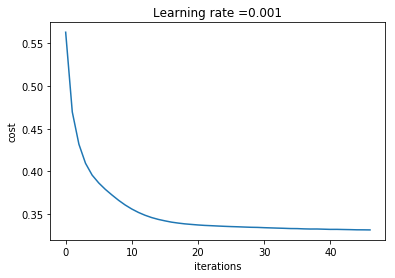


---Task 4 Question 1e---
Train accuracy: 0.26652756424335605
Test accuracy: 0.26552224784353917


In [36]:
mlp = MLPClassifier(random_state=rs, alpha = 0.001, hidden_layer_sizes=8, early_stopping=True)
mlp.fit(X_train_NN, y_train_NN)

print("---Task 4 Question 1a HAVE TO EXPLAIN---")
print(mlp)

print("\n---Task 4 Question 1b---")
print(mlp.n_iter_)

print("\n---Task 4 Question 1c---")
print("Slight overfitting as test accuracy is slightly lower than train accuracy.")

print("\n---Task 4 Question 1d---")
print("Yes. It converged and showed no improvements on 10 consecutive epochs therefore it was early stopped at epoch=32")
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("Learning rate =" + str(0.001))
plt.plot(mlp.loss_curve_)
plt.show()

print("\n---Task 4 Question 1e---")
print("Train accuracy:", mlp.score(X_train, y_train))
print("Test accuracy:", mlp.score(X_test, y_test))


---Task 4 Question 2a---
{'alpha': 0.001, 'hidden_layer_sizes': (15,), 'max_iter': 100}
MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(15,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=10, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

---Task 4 Question 2b---
54

---Task 4 Question 2c---
Insignificant overfitting as the difference etween test and train accuracy are very similar

---Task 4 Question 2d---


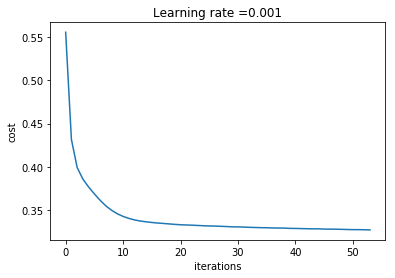


---Task 4 Question 2e---
Train accuracy: 0.8469141225565561
Test accuracy: 0.8443077974207874


In [37]:
params = {'hidden_layer_sizes': [(13,), (15,), (17,), (19,)], 'alpha': [0.001, 0.0001, 0.00001], 'max_iter': np.arange(100,250,50)}
mlpGS = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs, early_stopping=True))
mlpGS.fit(X_train_NN, y_train_NN)

print("\n---Task 4 Question 2a---")
print(mlpGS.best_params_)
print(mlpGS.best_estimator_)

print("\n---Task 4 Question 2b---")
print(mlpGS.best_estimator_.n_iter_)

print("\n---Task 4 Question 2c---")
print("Insignificant overfitting as the difference etween test and train accuracy are very similar")

print("\n---Task 4 Question 2d---")
plt.plot(mlpGS.best_estimator_.loss_curve_)
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("Learning rate =" + str(0.001))
plt.show()

print("\n---Task 4 Question 2e---")
print("Train accuracy:", mlpGS.score(X_train_NN, y_train_NN))
print("Test accuracy:", mlpGS.score(X_test_NN, y_test_NN))



# Task 4 question 3
## RFE Model on NN

In [ ]:
X_RFE = dfNN.drop(['ID', 'CapitalLoss', 'CapitalGain', 'AtRisk', 'Marital-Status', 'Occupation', 'Relationship', 'CapitalAvg', 'NumWorkingHoursPerWeek', 'Sex', 'CountryOfOrigin'], axis=1)

columns_to_transform = ['Age', 'NumYearsEducation', 'Weighting']
# transform the columns with np.log
for col in columns_to_transform:
    X_RFE[col] = X_RFE[col].apply(lambda x: x+1)
    X_RFE[col] = X_RFE[col].apply(np.log)
    
X_matRFE = X_RFE.as_matrix()
X_train_RFENN, X_test_RFENN, y_train_RFENN, y_test_RFENN = train_test_split(X_matRFE, y_NN, test_size=0.3, stratify=y, random_state=rs)

mlpRFE = MLPClassifier(random_state=rs, alpha = 0.0001, hidden_layer_sizes=5, max_iter=500, n_iter_no_change=30)
mlpRFE.fit(X_train_RFENN, y_train_RFENN)
print("---Task 4 Question 3a HAVE TO EXPLAIN---")
print("Inputs are Age, WorkClass, Weighting, Education, NumYearsEducation\n")
print("Features selection with RFE did not help and resulted in inconsistent results. The model settings are as below:\n")
print(mlpRFE)

print("\n---Task 4 Question 3b---")
print("Train accuracy:", mlpRFE.score(X_train_RFENN, y_train_RFENN))
print("Test accuracy:", mlpRFE.score(X_test_RFENN, y_test_RFENN))

print("\n---Task 4 Question 3c---")
print(mlpRFE.n_iter_)

print("\n---Task 4 Question 3d---")
print("No overfitting as test accuracy is higher than train accuracy.")

print("\n---Task 4 Question 3e---")
print("Yes it converges")
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("Learning rate =" + str(0.0001))
plt.plot(mlpRFE.loss_curve_)
plt.show()


In [ ]:
###### Task 3 Question 3F
###### RFE With GridSearchCV COMPUTATIONAL EXPENSIVE MODEL

params = params = {'hidden_layer_sizes': np.arange(3,11,2), 'alpha': [0.001, 0.0001, 0.00001], 'max_iter': np.arange(300,500,50)}

mlpRFEGS = GridSearchCV(param_grid=params, estimator=mlpRFE)
mlpRFEGS.fit(X_train_RFENN, y_train_RFENN)
print("\n---Task 4 Question 3f---")
print("\n RFE on GridSearchCV")
print("Train accuracy:", mlpRFEGS.score(X_train_RFENN, y_train_RFENN))
print("Test accuracy:", mlpRFEGS.score(X_test_RFENN, y_test_RFENN))
print(mlpRFEGS.best_param_)
plt.ylabel('cost')
plt.xlabel('iterations')
plt.plot(mlpRFEGS.best_estimator_.loss_curve_)
plt.show()


# Task 3 question 3
## Decision Tree Input on NN

In [ ]:
X_DT = dfNN.drop(['Age','WorkClass','Weighting','Education','Relationship','Sex','CountryOfOrigin'], axis=1)

columns_to_transform = ['NumYearsEducation', 'CapitalAvg']
# transform the columns with np.log
for col in columns_to_transform:
    X_DT[col] = X_DT[col].apply(lambda x: x+1)
    X_DT[col] = X_DT[col].apply(np.log)
    

X_mat_DTNN = X_DT.as_matrix()
X_train_DTNN, X_test_DTNN, y_train_DTNN, y_test_DTNN = train_test_split(X_mat_DTNN, y_NN, test_size=0.3, stratify=y, random_state=rs)

mlpDT = MLPClassifier(random_state=rs, alpha = 0.00001, hidden_layer_sizes=5, max_iter=500, n_iter_no_change=10)
mlpDT.fit(X_train_DTNN, y_train_DTNN)
print("---Task 4 Question 3a HAVE TO EXPLAIN---")
print("Inputs are Marital-Status NumYearsEducation CapitalAvg NumWorkingHoursPerWeek Occupation\n")
print("Features selection with RFE did not help and resulted in inconsistent results. The model settings are as below:\n")
print(mlpDT)

print("\n---Task 4 Question 3b---")
print("Train accuracy:", mlpDT.score(X_train, y_train))
print("Test accuracy:", mlpDT.score(X_test, y_test))

print("\n---Task 4 Question 3c---")
print(mlpDT.n_iter_)

print("\n---Task 4 Question 3d---")
print("No overfitting as test accuracy is higher than train accuracy.")

print("\n---Task 4 Question 3e---")
print("Yes it converged.")
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("Learning rate =" + str(0.001))
plt.plot(mlpDT.loss_curve_)
plt.show()




In [ ]:
X_mat = X_DT.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)

params = {'hidden_layer_sizes': np.arange(3,11,2), 'alpha': [0.001, 0.0001, 0.00001], 'max_iter': np.arange(300,500,50), 'n_iter_no_change': np.arange(30, 50, 10)}
mlpDTGS = GridSearchCV(param_grid=params, estimator=mlpDT)
mlpDTGS.fit(X_train, y_train)

print("\n RFE on GridSearchCV")
print("Train accuracy:", mlpDTGS.score(X_train, y_train))
print("Test accuracy:", mlpDTGS.score(X_test, y_test))

plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("Learning rate =" + str(0.001))
plt.plot(mlpDTGS.loss_curve_)
plt.show()

In [ ]:
print("\n DT Features on GridSearchCV")
print("Train accuracy:", mlpDTGS.score(X_train, y_train))
print("Test accuracy:", mlpDTGS.score(X_test, y_test))

plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("Learning rate =" + str(0.001))
plt.plot(mlpDTGS.best_estimator_.loss_curve_)
plt.show()

mlpDTGS.best_params_

In [ ]:
# ROC For all 3 models

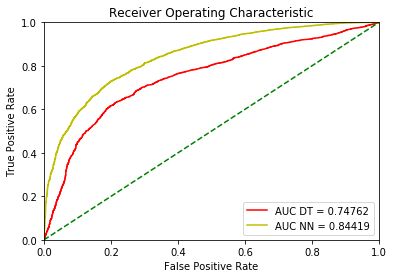

In [42]:

#LR
#probs = cv.predict_proba(X_test_log)
#preds = probs[:,1]
#fpr, tpr, threshold = roc_curve(y_test_log, preds)
#roc_auc = auc(fpr, tpr)
#plt.plot(fpr, tpr, 'b', label = 'AUC logreg = %0.5f' % roc_auc)

probs = cv.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'r', label = 'AUC DT = %0.5f' % roc_auc)

probs = cv.predict_proba(X_test_NN)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test_NN, preds)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'y', label = 'AUC NN = %0.5f' % roc_auc)


plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
